In [ ]:
import pandas as pd
import numpy as np
from scipy.stats import linregress
from sklearn.preprocessing import MinMaxScaler

# df 경로는 각자 설정
df = pd.read_csv(r"C:\Users\82103\Downloads\Final_merged_all_data.csv")
# df = df.sort_values(by=['발급회원번호', '기준년월'])

# -------------------------------------------------------
# 1. 6개월 기울기(Slope) 계산 (df에 바로 생성)
# -------------------------------------------------------
def calc_slope_6m(series):
    if len(series) < 2 or np.sum(series) == 0: return 0
    y = series.values
    x = np.arange(len(y))
    slope, _, _, _, _ = linregress(x, y)
    return slope

# transform으로 전체 데이터에 기울기 적용
df['Slope_Spend'] = df.groupby('발급회원번호')['이용금액_신용_B0M'].transform(calc_slope_6m)
df['Slope_Balance'] = df.groupby('발급회원번호')['잔액_B0M'].transform(calc_slope_6m)
df['Slope_Count'] = df.groupby('발급회원번호')['이용건수_신용_B0M'].transform(calc_slope_6m)

# -------------------------------------------------------
# 2. 현재 시점(12월) 데이터만 추출
# -------------------------------------------------------
target_month = df['기준년월'].max()
df_general = df[df['기준년월'] == target_month].copy()

# -------------------------------------------------------
# 3. [핵심] 기울기를 '이탈 점수'로 변환 (Normalization)
# -------------------------------------------------------
# 전략: 기울기가 음수일수록(가파른 감소) 높은 점수를 줍니다.
# 양수(증가)인 경우는 이탈 위험이 없으므로 0점으로 처리합니다.

scaler = MinMaxScaler()

def convert_slope_to_score(col_name):
    # 1. 감소하는 경우(음수)만 추출, 나머지는 0으로 대치
    # (음수 값에 -1을 곱해 양수로 만듦: -5000 -> 5000)
    # 즉, 값이 클수록 '많이 줄어듦'을 의미하게 됨
    negative_slopes = df_general[col_name].apply(lambda x: -x if x < 0 else 0)
    
    # 2. 0~1 사이 값으로 정규화 (MinMax Scaling)
    # 가장 많이 줄어든 사람이 1.0, 안 줄어든 사람이 0.0
    return scaler.fit_transform(negative_slopes.values.reshape(-1, 1)).flatten()

# 각 지표별 '감소 심각도' (0.0 ~ 1.0)
score_spend_norm = convert_slope_to_score('Slope_Spend')
score_balance_norm = convert_slope_to_score('Slope_Balance')
score_count_norm = convert_slope_to_score('Slope_Count')

# -------------------------------------------------------
# 4. 가중치 적용 및 최종 점수 산출 (100점 만점)
# -------------------------------------------------------
# 가중치 설정 (비즈니스 중요도에 따라 조절 가능)
W_SPEND = 40   # 소비 감소 비중
W_BALANCE = 30 # 잔액 감소(이탈준비) 비중
W_COUNT = 20   # 빈도 감소 비중
W_RISK = 10    # 현재 연체 등 리스크 비중

# (1) 리스크 점수 별도 계산 (0 or 10점)
# 연체나 승인거절이 하나라도 있으면 10점 만점 부여
has_risk = np.where(
    (df_final.get('연체잔액_B0M', 0) > 0) | 
    (df_final.get('승인거절건수_B0M', 0) > 0), 
    1, 0
)

# (2) 최종 스코어 계산
df_final['Churn_Score'] = (
    (score_spend_norm * W_SPEND) + 
    (score_balance_norm * W_BALANCE) + 
    (score_count_norm * W_COUNT) + 
    (has_risk * W_RISK)
)

# 소수점 정리
df_final['Churn_Score'] = df_final['Churn_Score'].round(1)

# 출력
print("\n[이탈 위험 점수(Churn Score) 상위 10명]")
cols_view = ['발급회원번호', 'Slope_Spend', 'Slope_Balance', 'Churn_Score']
print(df_final[cols_view].sort_values('Churn_Score', ascending=False).head(10))



[이탈 위험 점수(Churn Score) 상위 10명]
         발급회원번호    Slope_Spend  Slope_Balance  Churn_Score
56996  SYN_6996 -259949.057143 -466081.371429         65.5
52794  SYN_2794 -252282.000000 -115305.971429         59.9
53968  SYN_3968 -243906.428571 -117226.657143         51.1
59037  SYN_9037 -229686.857143 -119831.371429         47.7
55559  SYN_5559 -269313.542857  -44089.685714         45.9
53956  SYN_3956 -222279.228571 -168815.114286         42.1
55455  SYN_5455 -223850.714286  -61721.000000         41.3
55296  SYN_5296 -206826.314286 -381888.542857         41.0
53442  SYN_3442 -168908.285714 -186469.485714         39.1
51527  SYN_1527 -186951.657143 -241112.200000         38.0


In [ ]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
import pandas as pd

# 1. 분석할 Feature 리스트 정의
features = [
    '연속무실적개월수_기본_24M_카드', '회원여부_이용가능', '증감율_이용금액_신용_전월', '연체잔액_B0M',
    '이용후경과월_신용', '이용후경과월_신판', '이용개월수_신용_R6M', '이용개월수_신판_R6M',
    '이용개월수_일시불_R6M', '이용개월수_오프라인_R6M', '이용개월수_신용_R3M', '이용개월수_신판_R3M',
    '이용개월수_일시불_R3M', '이용개월수_신용_R12M', '이용개월수_신판_R12M', '이용개월수_일시불_R12M',
    '이용개월수_전체_R6M', '이용개월수_전체_R3M', '청구서발송여부_R6M', '청구서발송여부_R3M',
    '이용개월수_결제일_R6M', '이용후경과월_일시불', '청구서발송여부_B0', '이용개월수_결제일_R3M',
    '이용카드수_신용', '연속유실적개월수_기본_24M_카드', '상환개월수_결제일_R3M', '상환개월수_결제일_R6M',
    '이용카드수_신용체크', '증감율_이용금액_신판_전월', 'RP후경과월', '증감율_이용금액_일시불_전월',
    '회원여부_이용가능_CA', '이용여부_3M_해외겸용_신용_본인'
]

# 2. 데이터 준비 (numeric_df가 이미 메모리에 있다고 가정)
# 만약 numeric_df가 없다면 df_vip 등을 사용하세요.
X = numeric_df[features].copy()
X = X.apply(pd.to_numeric, errors='coerce').fillna(0)

# 3. VIF 기반 변수 선택 (Stepwise Removal)
vif_threshold = 10  # 기준값

print(f"--- VIF {vif_threshold} 기준 변수 최적화 시작 ---")

while True:
    # 현재 남은 변수들로 VIF 계산
    vif_data = pd.DataFrame()
    vif_data["feature"] = X.columns
    vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    
    # VIF가 가장 높은 변수 찾기
    max_vif = vif_data['VIF'].max()
    max_feature = vif_data.loc[vif_data['VIF'].idxmax(), 'feature']
    
    # 기준을 넘는지 확인
    if max_vif > vif_threshold:
        print(f"제거됨: {max_feature} (VIF: {max_vif:.2f})")
        # 가장 높은 것 하나만 삭제하고 다시 루프 시작
        X = X.drop(columns=[max_feature])
    else:
        # 모든 VIF가 기준 이하이면 종료
        print("\n=== 최적화 완료 (모든 VIF <= 10) ===")
        print(vif_data.sort_values(by='VIF', ascending=False))
        break

# 4. 최종 선택된 피처 리스트 출력
final_features = list(X.columns)
print(f"\n최종 선택된 피처 개수: {len(final_features)}")
print(f"최종 피처 리스트:\n{final_features}")

In [2]:
import pandas as pd

In [8]:
df = pd.read_csv(r"C:\Users\82103\Downloads\vip_customers_all.csv")

C:\Users\82103\AppData\Local\Temp\ipykernel_18120\1019069428.py:1: DtypeWarning: Columns (339) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(r"C:\Users\82103\Downloads\vip_customers_all.csv")


In [7]:
df_final.head()

,기준년월,발급회원번호,증감율_이용건수_신용_전월,증감율_이용건수_신판_전월,증감율_이용건수_일시불_전월,증감율_이용건수_할부_전월,증감율_이용건수_CA_전월,증감율_이용건수_체크_전월,증감율_이용건수_카드론_전월,증감율_이용금액_신용_전월,...,할인금액_제휴연회비_B0M,청구금액_기본연회비_B0M,청구금액_제휴연회비_B0M,상품관련면제카드수_B0M,임직원면제카드수_B0M,우수회원면제카드수_B0M,기타면제카드수_B0M,카드신청건수,Life_Stage,최종카드발급경과월
0,201807,SYN_0,0.454549,0.454549,0.364728,2.0,0.0,0.000000,0.0,0.409767,...,0,0,0,0,0,0,0,0,5.자녀성장기(2),22
1,201807,SYN_1000,0.204653,0.204653,0.204653,0.0,0.0,0.000000,0.0,1.411954,...,0,0,0,0,0,0,0,0,4.자녀성장기(1),45
2,201807,SYN_1005,0.148929,0.148929,0.099295,2.0,0.0,-0.019939,0.0,0.357926,...,0,0,0,0,0,0,0,1,2.가족형성기,8
3,201807,SYN_1007,-0.189322,-0.189322,-0.189322,0.0,0.0,0.000000,0.0,0.189824,...,0,0,0,0,0,0,0,0,3.자녀출산기,0
4,201807,SYN_1009,0.040080,0.040080,0.040080,0.0,0.0,-0.243847,0.0,0.204423,...,0,0,0,0,0,0,0,0,5.자녀성장기(2),22


In [9]:
import pandas as pd
import numpy as np
from scipy.stats import linregress
from sklearn.preprocessing import MinMaxScaler

# df 경로는 각자 설정
# df = df.sort_values(by=['발급회원번호', '기준년월'])

# -------------------------------------------------------
# 1. 6개월 기울기(Slope) 계산 (df에 바로 생성)
# -------------------------------------------------------
def calc_slope_6m(series):
    if len(series) < 2 or np.sum(series) == 0: return 0
    y = series.values
    x = np.arange(len(y))
    slope, _, _, _, _ = linregress(x, y)
    return slope

# transform으로 전체 데이터에 기울기 적용
df['Slope_Spend'] = df.groupby('발급회원번호')['이용금액_신용_B0M'].transform(calc_slope_6m)
df['Slope_Balance'] = df.groupby('발급회원번호')['잔액_B0M'].transform(calc_slope_6m)
df['Slope_Count'] = df.groupby('발급회원번호')['이용건수_신용_B0M'].transform(calc_slope_6m)

# -------------------------------------------------------
# 2. 현재 시점(12월) 데이터만 추출
# -------------------------------------------------------
target_month = df['기준년월'].max()
df_final = df[df['기준년월'] == target_month].copy()

# -------------------------------------------------------
# 3. [핵심] 기울기를 '이탈 점수'로 변환 (Normalization)
# -------------------------------------------------------
# 전략: 기울기가 음수일수록(가파른 감소) 높은 점수를 줍니다.
# 양수(증가)인 경우는 이탈 위험이 없으므로 0점으로 처리합니다.

scaler = MinMaxScaler()

def convert_slope_to_score(col_name):
    # 1. 감소하는 경우(음수)만 추출, 나머지는 0으로 대치
    # (음수 값에 -1을 곱해 양수로 만듦: -5000 -> 5000)
    # 즉, 값이 클수록 '많이 줄어듦'을 의미하게 됨
    negative_slopes = df_final[col_name].apply(lambda x: -x if x < 0 else 0)
    
    # 2. 0~1 사이 값으로 정규화 (MinMax Scaling)
    # 가장 많이 줄어든 사람이 1.0, 안 줄어든 사람이 0.0
    return scaler.fit_transform(negative_slopes.values.reshape(-1, 1)).flatten()

# 각 지표별 '감소 심각도' (0.0 ~ 1.0)
score_spend_norm = convert_slope_to_score('Slope_Spend')
score_balance_norm = convert_slope_to_score('Slope_Balance')
score_count_norm = convert_slope_to_score('Slope_Count')

# -------------------------------------------------------
# 4. 가중치 적용 및 최종 점수 산출 (100점 만점)
# -------------------------------------------------------
# 가중치 설정 (비즈니스 중요도에 따라 조절 가능)
W_SPEND = 40   # 소비 감소 비중
W_BALANCE = 30 # 잔액 감소(이탈준비) 비중
W_COUNT = 20   # 빈도 감소 비중
W_RISK = 10    # 현재 연체 등 리스크 비중

# (1) 리스크 점수 별도 계산 (0 or 10점)
# 연체나 승인거절이 하나라도 있으면 10점 만점 부여
has_risk = np.where(
    (df_final.get('연체잔액_B0M', 0) > 0) | 
    (df_final.get('승인거절건수_B0M', 0) > 0), 
    1, 0
)

# (2) 최종 스코어 계산
df_final['Churn_Score'] = (
    (score_spend_norm * W_SPEND) + 
    (score_balance_norm * W_BALANCE) + 
    (score_count_norm * W_COUNT) + 
    (has_risk * W_RISK)
)

# 소수점 정리
df_final['Churn_Score'] = df_final['Churn_Score'].round(1)

# 출력
print("\n[이탈 위험 점수(Churn Score) 상위 10명]")
cols_view = ['발급회원번호', 'Slope_Spend', 'Slope_Balance', 'Churn_Score']
print(df_final[cols_view].sort_values('Churn_Score', ascending=False).head(10))



[이탈 위험 점수(Churn Score) 상위 10명]
         발급회원번호    Slope_Spend  Slope_Balance  Churn_Score
10182  SYN_3968 -243906.428571 -117226.657143         63.7
10493  SYN_5296 -206826.314286 -381888.542857         55.4
11244  SYN_9037 -229686.857143 -119831.371429         54.9
10079  SYN_3442 -168908.285714 -186469.485714         51.4
9667   SYN_1527 -186951.657143 -241112.200000         49.6
10057   SYN_334 -153861.142857 -243873.228571         49.0
9803   SYN_2164 -150169.828571 -159142.771429         48.1
10522  SYN_5434 -161439.171429 -192306.314286         43.3
10539  SYN_5537 -172069.714286 -152554.742857         42.9
10603  SYN_5905 -170207.685714 -156450.228571         41.7



[클러스터별 평균 특성 확인]
            Churn_Score   Slope_Spend
Cluster_ID                           
0             27.715556 -84954.710349
1             11.438158 -24657.012782
2              2.380108  17327.987892


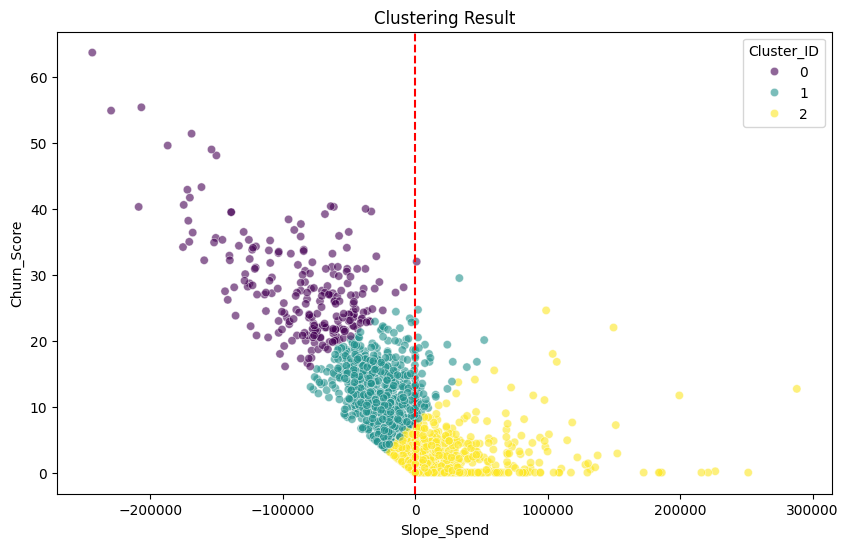

In [14]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# 1. 클러스터링에 사용할 핵심 변수 선택 (피드백 받은 Slope 변수 포함)
# 너무 많은 변수를 넣으면 시각화도 어렵고 군집이 잘 안 됩니다. 핵심만 넣으세요.
cluster_cols = ['Churn_Score', 'Slope_Spend']

# 데이터 준비 (결측치 처리 등은 되어있다고 가정)
X_cluster = df_final[cluster_cols].copy()

# 2. 스케일링 (필수: 변수 간 단위가 다르므로)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_cluster)

# 3. K-Means 클러스터링 (K=3 권장: 안전 / 잠재위험 / 고위험)
# K=2로 하면 너무 단순하게 나뉠 수 있어 3개로 보고 결정하는 게 좋습니다.
kmeans = KMeans(n_clusters=3, random_state=42)
clusters = kmeans.fit_predict(X_scaled)

# 원본 데이터에 클러스터 라벨 붙이기
df_final['Cluster_ID'] = clusters

# -------------------------------------------------------
# 4. 결과 해석 (각 그룹이 어떤 특징을 가지는지 통계 보기)
# -------------------------------------------------------
print("\n[클러스터별 평균 특성 확인]")
print(df_final.groupby('Cluster_ID')[cluster_cols].mean())

# 예시 해석:
# Cluster 0: Slope가 0 근처, 이용금액 높음 -> [충성 고객]
# Cluster 1: Slope가 약간 음수, 이용금액 보통 -> [일반 고객]
# Cluster 2: Slope가 매우 큰 음수, 이용금액 낮음 -> [이탈 위험군!]

# -------------------------------------------------------
# 5. 시각화 (2차원으로 차원 축소하지 않고, 2개 변수씩 짝지어 확인)
# -------------------------------------------------------
plt.figure(figsize=(10, 6))
# X축: 기울기(얼마나 줄었나), Y축: 현재 이용금액
sns.scatterplot(
    data=df_final, 
    x='Slope_Spend', 
    y='Churn_Score', 
    hue='Cluster_ID', 
    palette='viridis',
    alpha=0.6
)
plt.title('Clustering Result')
plt.axvline(x=0, color='r', linestyle='--') # 기울기 0 기준선
plt.show()


[클러스터별 평균 특성 확인]
            Churn_Score   Slope_Spend
Cluster_ID                           
0             27.715556 -84954.710349
1             11.438158 -24657.012782
2              2.380108  17327.987892


c:\Users\82103\Desktop\Python\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 51060 (\N{HANGUL SYLLABLE I}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\82103\Desktop\Python\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 53448 (\N{HANGUL SYLLABLE TAL}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\82103\Desktop\Python\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 51216 (\N{HANGUL SYLLABLE JEOM}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\82103\Desktop\Python\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 49688 (\N{HANGUL SYLLABLE SU}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\82103\Desktop\Python\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 49548 (\N{HANGUL SYLLABLE SO}) missing from f

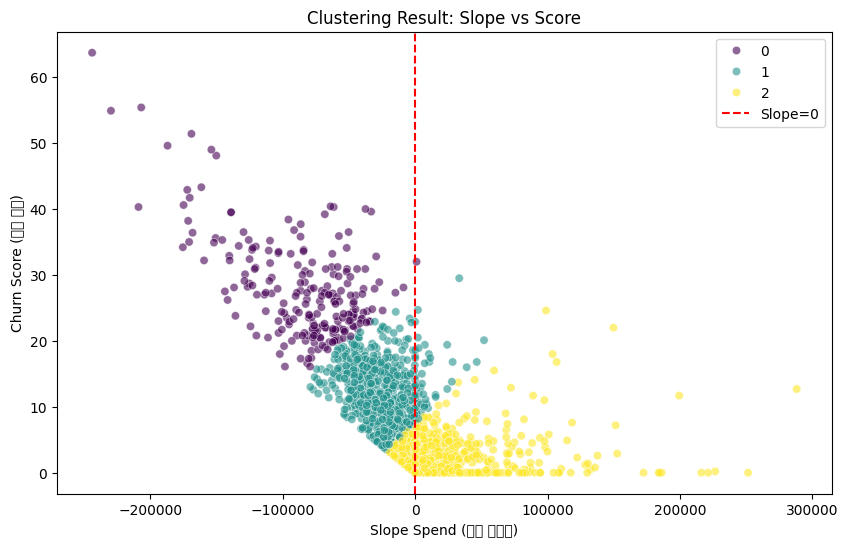

------------------------------
[클러스터별 분포 현황]
            인원수(명)  비율(%)
Cluster_ID               
0              225  11.78
1              760  39.79
2              925  48.43
------------------------------
▶ [Cluster 0] 위험군 비율: 11.78%
▶ [Cluster 0] 인원수: 225명


In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# 1. 클러스터링에 사용할 핵심 변수 선택
# (Churn_Score와 Slope_Spend 두 가지로 군집화)
cluster_cols = ['Churn_Score', 'Slope_Spend']

# 데이터 준비
X_cluster = df_final[cluster_cols].copy()

# 2. 스케일링 (필수)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_cluster)

# 3. K-Means 클러스터링 (K=3)
kmeans = KMeans(n_clusters=3, random_state=42)
clusters = kmeans.fit_predict(X_scaled)

# 원본 데이터에 클러스터 라벨 붙이기
df_final['Cluster_ID'] = clusters

# -------------------------------------------------------
# 4. 결과 해석 (통계)
# -------------------------------------------------------
print("\n[클러스터별 평균 특성 확인]")
print(df_final.groupby('Cluster_ID')[cluster_cols].mean())

# -------------------------------------------------------
# 5. 시각화 (수정됨: 클러스터링 변수와 축 일치시키기)
# -------------------------------------------------------
plt.figure(figsize=(10, 6))

# X축: 소비 기울기 (Slope_Spend)
# Y축: 이탈 점수 (Churn_Score)
sns.scatterplot(
    data=df_final, 
    x='Slope_Spend', 
    y='Churn_Score', 
    hue='Cluster_ID', 
    palette='viridis',
    alpha=0.6
)

plt.title('Clustering Result: Slope vs Score')
plt.xlabel('Slope Spend (소비 기울기)')
plt.ylabel('Churn Score (이탈 점수)')

# 기준선 추가 (보기 편하게)
plt.axvline(x=0, color='r', linestyle='--', label='Slope=0') 
plt.legend()
plt.show()

# -------------------------------------------------------
# 6. 클러스터 0 (또는 특정 그룹) 비중 확인 코드
# -------------------------------------------------------
# 전체 인원수 및 비율 계산
cluster_counts = df_final['Cluster_ID'].value_counts().sort_index()
cluster_ratios = df_final['Cluster_ID'].value_counts(normalize=True).sort_index() * 100

print("-" * 30)
print("[클러스터별 분포 현황]")
df_summary = pd.DataFrame({
    '인원수(명)': cluster_counts,
    '비율(%)': cluster_ratios.round(2)
})
print(df_summary)
print("-" * 30)

# 만약 0번 그룹을 위험군으로 본다면:
target_group = 0 
print(f"▶ [Cluster {target_group}] 위험군 비율: {cluster_ratios[target_group]:.2f}%")
print(f"▶ [Cluster {target_group}] 인원수: {cluster_counts[target_group]:,}명")

In [12]:
# -------------------------------------------------------
# 클러스터별 인원수 및 비율 확인 코드
# -------------------------------------------------------

# 1. 각 클러스터별 개수(Count) 계산
cluster_counts = df_final['Cluster_ID'].value_counts().sort_index()

# 2. 각 클러스터별 비율(Percentage) 계산
cluster_ratios = df_final['Cluster_ID'].value_counts(normalize=True).sort_index() * 100

# 3. 보기 좋게 데이터프레임으로 합치기
cluster_summary = pd.DataFrame({
    '인원수(명)': cluster_counts,
    '비율(%)': cluster_ratios.round(2) # 소수점 둘째자리까지 반올림
})

print("\n[클러스터별 분포 현황]")
print(cluster_summary)

print("-" * 30)

# -------------------------------------------------------
# 4. (핵심) Cluster 0 에 대한 집중 확인
# -------------------------------------------------------
target_id = 0
count_0 = cluster_counts.get(target_id, 0)
ratio_0 = cluster_ratios.get(target_id, 0)

print(f"▶ 타겟으로 설정할 [Cluster {target_id}] 분석 결과:")
print(f"   - 해당 그룹 인원: {count_0:,} 명")
print(f"   - 전체 대비 비중: {ratio_0:.2f} %")

# 비즈니스 적합성 판단 가이드
if 5 <= ratio_0 <= 20:
    print("\n[판단] ✅ 이탈 위험군 비율이 이상적입니다 (5~20%). 타겟(1)으로 설정하기 좋습니다.")
elif ratio_0 < 5:
    print("\n[판단] ⚠️ 비율이 너무 적습니다 (5% 미만). 데이터 불균형 처리가 필요할 수 있습니다.")
else:
    print("\n[판단] ⚠️ 비율이 꽤 높습니다 (20% 초과). '위험군'의 기준이 다소 넓게 잡혔을 수 있습니다.")


[클러스터별 분포 현황]
            인원수(명)  비율(%)
Cluster_ID               
0              225  11.78
1              760  39.79
2              925  48.43
------------------------------
▶ 타겟으로 설정할 [Cluster 0] 분석 결과:
   - 해당 그룹 인원: 225 명
   - 전체 대비 비중: 11.78 %

[판단] ✅ 이탈 위험군 비율이 이상적입니다 (5~20%). 타겟(1)으로 설정하기 좋습니다.


In [15]:
df_general = pd.read_csv(r"C:\Users\82103\Downloads\general_customers_all.csv")

C:\Users\82103\AppData\Local\Temp\ipykernel_18120\736701052.py:1: DtypeWarning: Columns (254) have mixed types. Specify dtype option on import or set low_memory=False.
  df_general = pd.read_csv(r"C:\Users\82103\Downloads\general_customers_all.csv")


In [17]:
import pandas as pd
import numpy as np
from scipy.stats import linregress
from sklearn.preprocessing import MinMaxScaler

# df 경로는 각자 설정
# df = df.sort_values(by=['발급회원번호', '기준년월'])

# -------------------------------------------------------
# 1. 6개월 기울기(Slope) 계산 (df에 바로 생성)
# -------------------------------------------------------
def calc_slope_6m(series):
    if len(series) < 2 or np.sum(series) == 0: return 0
    y = series.values
    x = np.arange(len(y))
    slope, _, _, _, _ = linregress(x, y)
    return slope

# transform으로 전체 데이터에 기울기 적용
df['Slope_Spend'] = df.groupby('발급회원번호')['이용금액_신용_B0M'].transform(calc_slope_6m)
df['Slope_Balance'] = df.groupby('발급회원번호')['잔액_B0M'].transform(calc_slope_6m)
df['Slope_Count'] = df.groupby('발급회원번호')['이용건수_신용_B0M'].transform(calc_slope_6m)

# -------------------------------------------------------
# 2. 현재 시점(12월) 데이터만 추출
# -------------------------------------------------------
target_month = df['기준년월'].max()
df_general = df[df['기준년월'] == target_month].copy()

# -------------------------------------------------------
# 3. [핵심] 기울기를 '이탈 점수'로 변환 (Normalization)
# -------------------------------------------------------
# 전략: 기울기가 음수일수록(가파른 감소) 높은 점수를 줍니다.
# 양수(증가)인 경우는 이탈 위험이 없으므로 0점으로 처리합니다.

scaler = MinMaxScaler()

def convert_slope_to_score(col_name):
    # 1. 감소하는 경우(음수)만 추출, 나머지는 0으로 대치
    # (음수 값에 -1을 곱해 양수로 만듦: -5000 -> 5000)
    # 즉, 값이 클수록 '많이 줄어듦'을 의미하게 됨
    negative_slopes = df_general[col_name].apply(lambda x: -x if x < 0 else 0)
    
    # 2. 0~1 사이 값으로 정규화 (MinMax Scaling)
    # 가장 많이 줄어든 사람이 1.0, 안 줄어든 사람이 0.0
    return scaler.fit_transform(negative_slopes.values.reshape(-1, 1)).flatten()

# 각 지표별 '감소 심각도' (0.0 ~ 1.0)
score_spend_norm = convert_slope_to_score('Slope_Spend')
score_balance_norm = convert_slope_to_score('Slope_Balance')
score_count_norm = convert_slope_to_score('Slope_Count')

# -------------------------------------------------------
# 4. 가중치 적용 및 최종 점수 산출 (100점 만점)
# -------------------------------------------------------
# 가중치 설정 (비즈니스 중요도에 따라 조절 가능)
W_SPEND = 40   # 소비 감소 비중
W_BALANCE = 30 # 잔액 감소(이탈준비) 비중
W_COUNT = 20   # 빈도 감소 비중
W_RISK = 10    # 현재 연체 등 리스크 비중

# (1) 리스크 점수 별도 계산 (0 or 10점)
# 연체나 승인거절이 하나라도 있으면 10점 만점 부여
has_risk = np.where(
    (df_general.get('연체잔액_B0M', 0) > 0) | 
    (df_general.get('승인거절건수_B0M', 0) > 0), 
    1, 0
)

# (2) 최종 스코어 계산
df_general['Churn_Score'] = (
    (score_spend_norm * W_SPEND) + 
    (score_balance_norm * W_BALANCE) + 
    (score_count_norm * W_COUNT) + 
    (has_risk * W_RISK)
)

# 소수점 정리
df_general['Churn_Score'] = df_general['Churn_Score'].round(1)

# 출력
print("\n[이탈 위험 점수(Churn Score) 상위 10명]")
cols_view = ['발급회원번호', 'Slope_Spend', 'Slope_Balance', 'Churn_Score']
print(df_general[cols_view].sort_values('Churn_Score', ascending=False).head(10))



[이탈 위험 점수(Churn Score) 상위 10명]
         발급회원번호    Slope_Spend  Slope_Balance  Churn_Score
10182  SYN_3968 -243906.428571 -117226.657143         63.7
10493  SYN_5296 -206826.314286 -381888.542857         55.4
11244  SYN_9037 -229686.857143 -119831.371429         54.9
10079  SYN_3442 -168908.285714 -186469.485714         51.4
9667   SYN_1527 -186951.657143 -241112.200000         49.6
10057   SYN_334 -153861.142857 -243873.228571         49.0
9803   SYN_2164 -150169.828571 -159142.771429         48.1
10522  SYN_5434 -161439.171429 -192306.314286         43.3
10539  SYN_5537 -172069.714286 -152554.742857         42.9
10603  SYN_5905 -170207.685714 -156450.228571         41.7



[클러스터별 평균 특성 확인]
            Churn_Score   Slope_Spend
Cluster_ID                           
0             27.715556 -84954.710349
1             11.438158 -24657.012782
2              2.380108  17327.987892


c:\Users\82103\Desktop\Python\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 51060 (\N{HANGUL SYLLABLE I}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\82103\Desktop\Python\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 53448 (\N{HANGUL SYLLABLE TAL}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\82103\Desktop\Python\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 51216 (\N{HANGUL SYLLABLE JEOM}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\82103\Desktop\Python\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 49688 (\N{HANGUL SYLLABLE SU}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\82103\Desktop\Python\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 49548 (\N{HANGUL SYLLABLE SO}) missing from f

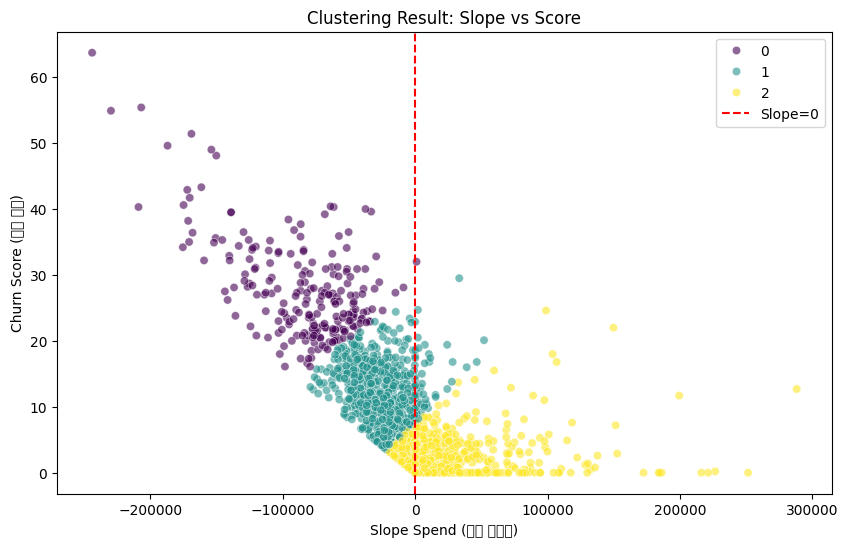

------------------------------
[클러스터별 분포 현황]
            인원수(명)  비율(%)
Cluster_ID               
0              225  11.78
1              760  39.79
2              925  48.43
------------------------------
▶ [Cluster 0] 위험군 비율: 11.78%
▶ [Cluster 0] 인원수: 225명


In [16]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# 1. 클러스터링에 사용할 핵심 변수 선택
# (Churn_Score와 Slope_Spend 두 가지로 군집화)
cluster_cols = ['Churn_Score', 'Slope_Spend']

# 데이터 준비
X_cluster = df_final[cluster_cols].copy()

# 2. 스케일링 (필수)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_cluster)

# 3. K-Means 클러스터링 (K=3)
kmeans = KMeans(n_clusters=3, random_state=42)
clusters = kmeans.fit_predict(X_scaled)

# 원본 데이터에 클러스터 라벨 붙이기
df_final['Cluster_ID'] = clusters

# -------------------------------------------------------
# 4. 결과 해석 (통계)
# -------------------------------------------------------
print("\n[클러스터별 평균 특성 확인]")
print(df_final.groupby('Cluster_ID')[cluster_cols].mean())

# -------------------------------------------------------
# 5. 시각화 (수정됨: 클러스터링 변수와 축 일치시키기)
# -------------------------------------------------------
plt.figure(figsize=(10, 6))

# X축: 소비 기울기 (Slope_Spend)
# Y축: 이탈 점수 (Churn_Score)
sns.scatterplot(
    data=df_final, 
    x='Slope_Spend', 
    y='Churn_Score', 
    hue='Cluster_ID', 
    palette='viridis',
    alpha=0.6
)

plt.title('Clustering Result: Slope vs Score')
plt.xlabel('Slope Spend (소비 기울기)')
plt.ylabel('Churn Score (이탈 점수)')

# 기준선 추가 (보기 편하게)
plt.axvline(x=0, color='r', linestyle='--', label='Slope=0') 
plt.legend()
plt.show()

# -------------------------------------------------------
# 6. 클러스터 0 (또는 특정 그룹) 비중 확인 코드
# -------------------------------------------------------
# 전체 인원수 및 비율 계산
cluster_counts = df_final['Cluster_ID'].value_counts().sort_index()
cluster_ratios = df_final['Cluster_ID'].value_counts(normalize=True).sort_index() * 100

print("-" * 30)
print("[클러스터별 분포 현황]")
df_summary = pd.DataFrame({
    '인원수(명)': cluster_counts,
    '비율(%)': cluster_ratios.round(2)
})
print(df_summary)
print("-" * 30)

# 만약 0번 그룹을 위험군으로 본다면:
target_group = 0 
print(f"▶ [Cluster {target_group}] 위험군 비율: {cluster_ratios[target_group]:.2f}%")
print(f"▶ [Cluster {target_group}] 인원수: {cluster_counts[target_group]:,}명")